# 1.导入依赖包

In [25]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow.keras
from tqdm import tqdm
import threading

In [26]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 2.导入数据集

In [27]:
path_train_test = r'D:\xiaoyi\jupyter location\4. Audio(all)\data\train_test'

In [28]:
train_dir = os.path.join(path_train_test, 'train_audio')
test_dir = os.path.join(path_train_test, 'test_audio')

In [29]:
Materials = os.listdir(train_dir)
Materials

['gravel',
 'M1(gravel+sand)',
 'M2(sand+silicarock)',
 'M3(gravel+silicarock)',
 'regolith',
 'sand',
 'silicarock']

In [30]:
Label_material = {'gravel':0, 'M1(gravel+sand)':1, 'M2(sand+silicarock)':2, 'M3(gravel+silicarock)':3, 'regolith':5, 'sand':4, 'silicarock':6}

In [31]:
def ZRC(data, length):
    y = librosa.feature.zero_crossing_rate(data, frame_length=5000, hop_length=1000)
    y_ = list(y[0])
    ind = y_.index(max(y_))
    index = ind*1000
    if index<(length/2):
        return(data[:length])
    else:
        return(data[int(index-(length/2)): int(index+(length/2))])

In [32]:
def FeaturesAccquir1000(path):
    Materials = os.listdir(path)
    Features = []
    labels = []
    for mater_name in tqdm(Materials):        
        path_material_ = os.path.join(path, mater_name)
        wave_list = os.listdir(path_material_)
        for name_wave in wave_list:
            labels.append(Label_material[mater_name])
            wave_path_sigle = os.path.join(path_material_, name_wave)
            y, sr = librosa.load(wave_path_sigle, mono=True)
            signal_filter = ZRC(y, 4000)
            Features.append(y)
    return Features, labels

In [9]:
class Train_Test(threading.Thread):
    def __init__(self, path):
        super(Train_Test, self).__init__()
        self.path = path
    def run(self):
        print('开始转换！')
        self.result = FeaturesAccquir1000(self.path)
        print('转换结束！')
    def get_result(self):
        try:  
            return self.result  
        except Exception as e:  
            return None

thread1 = Train_Test(train_dir)
thread2 = Train_Test(test_dir)

thread_lists = [thread1, thread2]
for thread in thread_lists:
    thread.start()
thread.join()

开始转换！
开始转换！


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  3.96s/it]

转换结束！


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:02<00:00,  8.82s/it]


转换结束！


In [10]:
x_train, y_train  =  thread1.get_result()
x_test, y_test =  thread2.get_result()

In [11]:
# x_train, y_train =  FeaturesAccquir1000(train_dir)
# x_test, y_test =  FeaturesAccquir1000(test_dir)

In [12]:
len(y_test), len(y_train)

(1116, 2508)

# 1.决策树

In [33]:
from sklearn.tree import DecisionTreeClassifier  # 导入DecisionTreeClassifier函数
from sklearn.model_selection import train_test_split
from sklearn import metrics  # 分类结果评价函数
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import time
from sklearn.metrics import plot_confusion_matrix

In [34]:
(np.array(x_train[0])).shape

(32057,)

In [35]:
model = DecisionTreeClassifier(criterion="entropy", random_state=42)  # 实例化模型DecisionTreeClassifier()
model.fit(x_train, y_train)  # 在训练集上训练模型\import pickle

ValueError: setting an array element with a sequence.

In [15]:
dir_weight = r"./data/Final/weights/1000"
NAME = 'DT_1000'
path_weight = dir_weight +'/'+NAME+ ".pkl"
with open(path_weight, "wb") as f:
    pickle.dump(model, f)

### 测试

输出结果，精确度、召回率、f-1分数：
               precision    recall  f1-score   support

           0     0.2105    0.2038    0.2071       157
           1     0.3099    0.2500    0.2767       176
           2     0.4375    0.4698    0.4531       149
           3     0.3377    0.2898    0.3119       176
           4     0.3457    0.3846    0.3641       169
           5     0.2132    0.1883    0.2000       154
           6     0.1979    0.2741    0.2298       135

    accuracy                         0.2939      1116
   macro avg     0.2932    0.2943    0.2918      1116
weighted avg     0.2959    0.2939    0.2930      1116

混淆矩阵：
 [[32 27  9 27 30 11 21]
 [25 44 12 23 16 31 25]
 [ 4  7 70  3 20 15 30]
 [30 25  4 51 17 25 24]
 [22  8 20 18 65 12 24]
 [26 20 18 13 22 29 26]
 [13 11 27 16 18 13 37]]
time cost:0.033073ms
Accuracy: 29.3907%


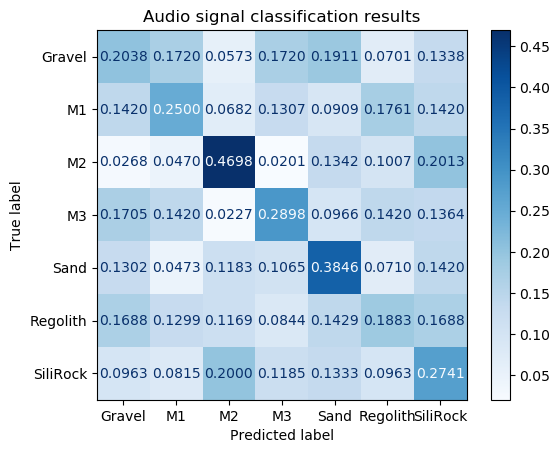

In [16]:
start = time.perf_counter()

with open(path_weight, "rb") as f:
    model = pickle.load(f)
    
expected = y_test  # 测试样本的期望输出
predicted = model.predict(x_test)  # 测试样本预测
end = time.perf_counter()


# 画出训练后模型的混淆矩阵，方便观察训练的效果
target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']

plot_confusion_matrix(
    model,
    x_test,
    y_test,
    display_labels= target_name,
    cmap="Blues",
    normalize="true",
    values_format='.4f',
)

a = metrics.classification_report(expected, predicted, digits=4)
b = metrics.confusion_matrix(expected, predicted)
c = metrics.accuracy_score(y_test, predicted)
d = ((end - start)/len(y_test))*1000

print("输出结果，精确度、召回率、f-1分数：\n", a)
print("混淆矩阵：\n", b)

print("time cost:%.6fms" % d) 
print("Accuracy: %.4f%%" % (c * 100.0))

plt.title("Audio signal classification results")
plt.savefig(r'./data/Final/ResultRecord/FusionMatrix/1000'+'/'+NAME +'.png')
plt.show()

record_ = [a, b, "Accuracy: %.4f%%" % (c * 100.0), "time cost:%.6fms" % d]
for i_ in record_:
    with open('./data/Final/ResultRecord/metrics/1000'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

# 2. 随机森林

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  # 分类结果评价函数
from sklearn.metrics import plot_confusion_matrix
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [18]:
target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']
randomforest = RandomForestClassifier(random_state=42, n_estimators=120)
randomforest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=120, random_state=42)

In [19]:
dir_weight = r"./data/Final/weights/1000"
NAME = 'RF_1000'
path_weight = dir_weight +'/'+NAME+ ".pkl"
with open(path_weight, "wb") as f:
    pickle.dump(randomforest, f)

In [20]:
path_weight

'./data/Final/weights/1000/RF_1000.pkl'

### 测试

输出结果，精确度、召回率、f-1分数：
               precision    recall  f1-score   support

           0     0.2612    0.4076    0.3184       157
           1     0.5055    0.5227    0.5140       176
           2     0.5415    0.7450    0.6271       149
           3     0.6000    0.6307    0.6150       176
           4     0.6107    0.4734    0.5333       169
           5     0.3918    0.2468    0.3028       154
           6     0.4366    0.2296    0.3010       135

    accuracy                         0.4722      1116
   macro avg     0.4782    0.4651    0.4588      1116
weighted avg     0.4827    0.4722    0.4655      1116

混淆矩阵：
 [[ 64  25   2  27  23  15   1]
 [ 33  92   2  14   8  24   3]
 [ 13   2 111   0   0   4  19]
 [ 35  22   0 111   6   2   0]
 [ 42   9  23   4  80   9   2]
 [ 30  21  30  12   8  38  15]
 [ 28  11  37  17   6   5  31]]
time cost:0.082783ms
Accuracy: 47.2222%


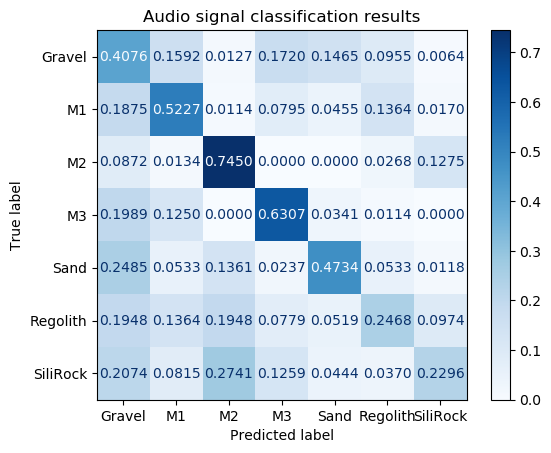

In [21]:
start = time.perf_counter()

with open(path_weight, "rb") as f:
    model = pickle.load(f)
    
expected = y_test  # 测试样本的期望输出
predicted = model.predict(x_test)  # 测试样本预测
end = time.perf_counter()


# 画出训练后模型的混淆矩阵，方便观察训练的效果
target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']

plot_confusion_matrix(
    model,
    x_test,
    y_test,
    display_labels= target_name,
    cmap="Blues",
    normalize="true",
    values_format='.4f',
)

a = metrics.classification_report(expected, predicted, digits=4)
b = metrics.confusion_matrix(expected, predicted)
c = metrics.accuracy_score(y_test, predicted)
d = ((end - start)/len(y_test))*1000

print("输出结果，精确度、召回率、f-1分数：\n", a)
print("混淆矩阵：\n", b)

print("time cost:%.6fms" % d) 
print("Accuracy: %.4f%%" % (c * 100.0))

plt.title("Audio signal classification results")
plt.savefig(r'./data/Final/ResultRecord/FusionMatrix/1000'+'/'+NAME +'.png')
plt.show()

record_ = [a, b, "Accuracy: %.4f%%" % (c * 100.0), "time cost:%.6fms" % d]
for i_ in record_:
    with open('./data/Final/ResultRecord/metrics/1000'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

# 3. 数据降维：主成分分析（PCA）

# 3-1. RF+PCA

In [59]:
from sklearn.decomposition import PCA
from typing import Any
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  # 分类结果评价函数
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import os
import numpy as np
import pandas as pd
import pickle

In [70]:
pca = PCA(n_components = 7)   #降到16维
pca.fit(x_train)                  #训练
newX = pca.fit_transform(x_train)   #降维后的数据


target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']

# 创建一个随机森林分类器的实例
PCA_RF = RandomForestClassifier(random_state=100, n_estimators=120)

# 利用训练集样本对分类器模型进行训练
PCA_RF.fit(newX, y_train)

RandomForestClassifier(n_estimators=120, random_state=100)

In [71]:
dir_weight = r"./data/Final/weights"
NAME = 'PCA_RF'
path_weight = dir_weight +'/'+NAME+ ".pkl"
with open(path_weight, "wb") as f:
    pickle.dump(PCA_RF, f)

### 测试

输出结果，精确度、召回率、f-1分数：
               precision    recall  f1-score   support

           0     0.5484    0.6497    0.5948       157
           1     0.3688    0.2955    0.3281       176
           2     0.8652    0.8188    0.8414       149
           3     0.8224    0.7102    0.7622       176
           4     0.7660    0.8521    0.8067       169
           5     0.4329    0.4610    0.4465       154
           6     0.6042    0.6444    0.6237       135

    accuracy                         0.6299      1116
   macro avg     0.6297    0.6331    0.6290      1116
weighted avg     0.6293    0.6299    0.6272      1116

混淆矩阵：
 [[102  40   0   0   3  12   0]
 [ 40  52   0   1  12  71   0]
 [  0   0 122   6   1   1  19]
 [  1   0   4 125  10   4  32]
 [  6   7   1   2 144   3   6]
 [ 33  42   3   0   5  71   0]
 [  4   0  11  18  13   2  87]]
time cost:0.087186ms
Accuracy: 62.9928%


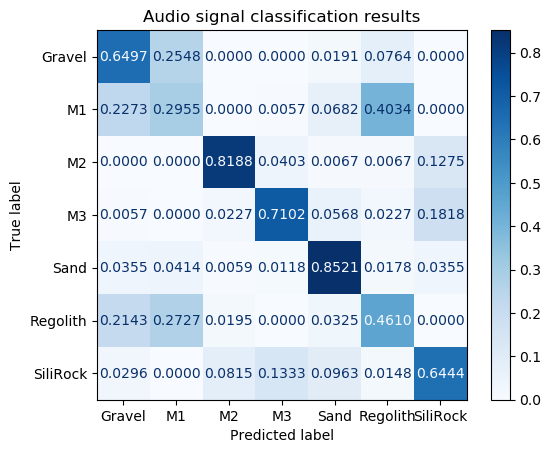

In [72]:
start = time.perf_counter()

with open(path_weight, "rb") as f:
    model = pickle.load(f)
    
pca_test = pca   #降到16维
pca_test.fit(x_test)                  #训练
x_test=pca_test.fit_transform(x_test)

expected = y_test  # 测试样本的期望输出
predicted = model.predict(x_test)  # 测试样本预测
end = time.perf_counter()

# 画出训练后模型的混淆矩阵，方便观察训练的效果
target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']

plot_confusion_matrix(
    model,
    x_test,
    y_test,
    display_labels= target_name,
    cmap="Blues",
    normalize="true",
    values_format='.4f',
)

a = metrics.classification_report(expected, predicted, digits=4)
b = metrics.confusion_matrix(expected, predicted)
c = metrics.accuracy_score(y_test, predicted)
d = ((end - start)/len(y_test))*1000

print("输出结果，精确度、召回率、f-1分数：\n", a)
print("混淆矩阵：\n", b)

print("time cost:%.6fms" % d) 
print("Accuracy: %.4f%%" % (c * 100.0))

plt.title("Audio signal classification results")
plt.savefig(r'./data/Final/ResultRecord/FusionMatrix'+'/'+NAME +'.png')
plt.show()

record_ = [a, b, "Accuracy: %.4f%%" % (c * 100.0), "time cost:%.6fms" % d]
for i_ in record_:
    with open('./data/Final/ResultRecord/metrics'+'/'+NAME+'.txt','a') as f:
        f.write(str(i_)+'\n')

## 3-2. PCA+决策树

In [73]:
pca = PCA(n_components = 7)   #降到16维
pca.fit(x_train)                  #训练
newX = pca.fit_transform(x_train)   #降维后的数据

In [74]:
PCA_DT_26 = DecisionTreeClassifier(criterion="gini", random_state=20)  # 实例化模型DecisionTreeClassifier()
PCA_DT_26.fit(newX, y_train) 

DecisionTreeClassifier(random_state=20)

In [75]:
dir_weight = r"./data/Final/weights"
NAME = 'PCA_DT_26'
path_weight = dir_weight +'/'+NAME+ ".pkl"
with open(path_weight, "wb") as f:
    pickle.dump(PCA_DT_26, f)

输出结果，精确度、召回率、f-1分数：
               precision    recall  f1-score   support

           0     0.5467    0.5223    0.5342       157
           1     0.4118    0.3580    0.3830       176
           2     0.7117    0.7785    0.7436       149
           3     0.6694    0.4716    0.5533       176
           4     0.7310    0.7396    0.7353       169
           5     0.5091    0.5455    0.5266       154
           6     0.4895    0.6889    0.5723       135

    accuracy                         0.5789      1116
   macro avg     0.5813    0.5863    0.5783      1116
weighted avg     0.5826    0.5789    0.5753      1116

混淆矩阵：
 [[ 82  42   3   3   4  12  11]
 [ 33  63   2   9  19  49   1]
 [  1   0 116   5   4   1  22]
 [  7   3  14  83   7  11  51]
 [  5  10   6   8 125   5  10]
 [ 18  33   4   8   5  84   2]
 [  4   2  18   8   7   3  93]]
time cost:0.021311ms
Accuracy: 57.8853%


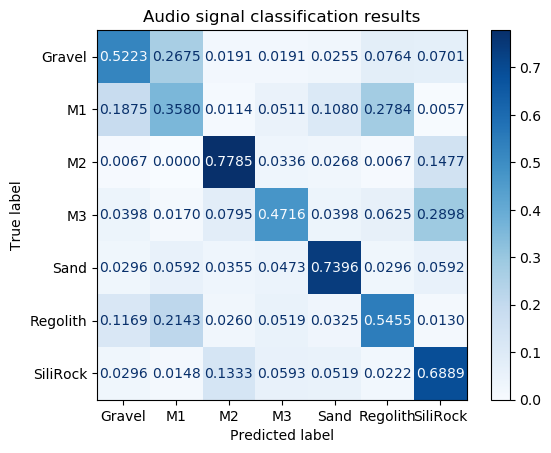

In [76]:
start = time.perf_counter()

with open(path_weight, "rb") as f:
    model = pickle.load(f)
    
pca_test = pca   #降到16维
pca_test.fit(x_test)                  #训练
x_test=pca_test.fit_transform(x_test)

expected = y_test  # 测试样本的期望输出
predicted = model.predict(x_test)  # 测试样本预测
end = time.perf_counter()

# 画出训练后模型的混淆矩阵，方便观察训练的效果
target_name=["Gravel", 'M1', 'M2', 'M3', "Sand", "Regolith", 'SiliRock']

plot_confusion_matrix(
    model,
    x_test,
    y_test,
    display_labels= target_name,
    cmap="Blues",
    normalize="true",
    values_format='.4f',
)

a = metrics.classification_report(expected, predicted, digits=4)
b = metrics.confusion_matrix(expected, predicted)
c = metrics.accuracy_score(y_test, predicted)
d = ((end - start)/len(y_test))*1000

print("输出结果，精确度、召回率、f-1分数：\n", a)
print("混淆矩阵：\n", b)

print("time cost:%.6fms" % d) 
print("Accuracy: %.4f%%" % (c * 100.0))

plt.title("Audio signal classification results")
plt.savefig(r'./data/Final/ResultRecord/FusionMatrix'+'/'+NAME +'.png')
plt.show()

# record_ = [a, b, "Accuracy: %.4f%%" % (c * 100.0), "time cost:%.6fms" % d]
# for i_ in record_:
#     with open('./data/Final/ResultRecord/metrics'+'/'+NAME+'.txt','a') as f:
#         f.write(str(i_)+'\n')